# Descripción
Un avión vuela con velocidad 
$V$
 a 
$Ha$
 metros del suelo en dirección a un cañón como se muestra en la figura.

El cañón tiene forma de trapecio isósceles invertido, de una altura 
$H
c$
, largo 
$L$
 y ángulo 
$α$
 con respecto al horizonte.

Cuando se encuentra a una distancia 
$d$
 del borde del cañón, el avión suelta una bomba.

![Imagen](im2.png)



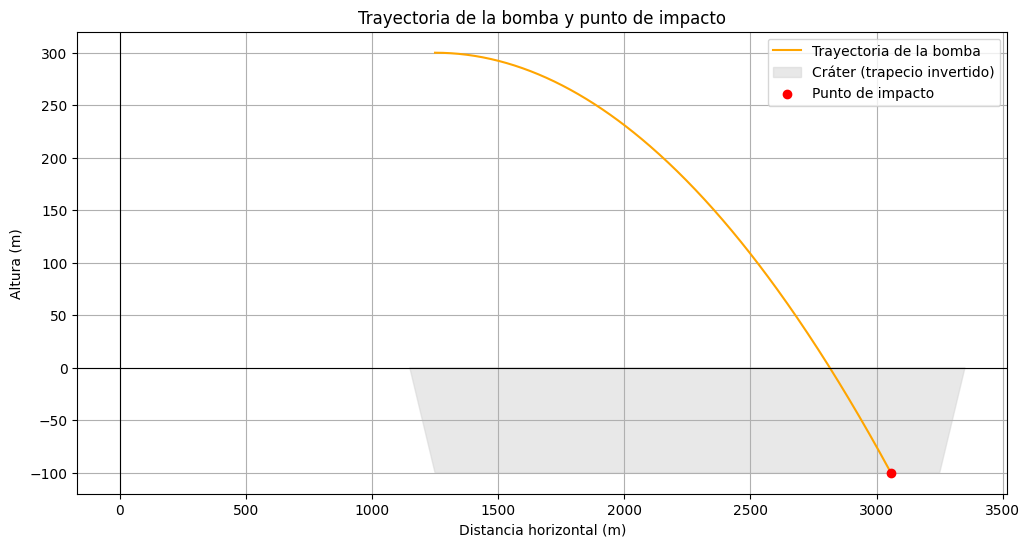

Punto de impacto: x = 3056.31 m, y = -100.00 m


In [7]:
import numpy as np
import matplotlib.pyplot as plt

ha = 300
hc = -100
L = 2000
alpha = np.radians(45)
d = 1250
v0 = 200

v0x = v0
v0y = 0

g = 9.81
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

x_crater = [
    d,
    d + (hc / np.tan(alpha)),
    d + L - (hc / np.tan(alpha)),
    d + L
]
y_crater = [hc, 0, 0, hc]

x0 = d
y0 = ha
x_trayectoria = np.linspace(x0, x0 + L + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)

impacto_x = None
for i in range(len(x_trayectoria)):
    if y_trayectoria[i] <= hc:
        impacto_x = x_trayectoria[i]
        impacto_y = hc
        break

if impacto_x and impacto_y:
    x_trayectoria_recortada = x_trayectoria[x_trayectoria <= impacto_x]
    y_trayectoria_recortada = y_trayectoria[:len(x_trayectoria_recortada)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_trayectoria_recortada, y_trayectoria_recortada, label="Trayectoria de la bomba", color="orange")
    plt.fill(x_crater, y_crater, color="lightgrey", label="Cráter (trapecio invertido)", alpha=0.5)

    plt.scatter(impacto_x, impacto_y, color="red", label="Punto de impacto", zorder=5)

    plt.axhline(0, color="black", linewidth=0.8)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title("Trayectoria de la bomba y punto de impacto")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Punto de impacto: x = {impacto_x:.2f} m, y = {impacto_y:.2f} m")
else:
    print("La bomba no impactó dentro del cráter.")


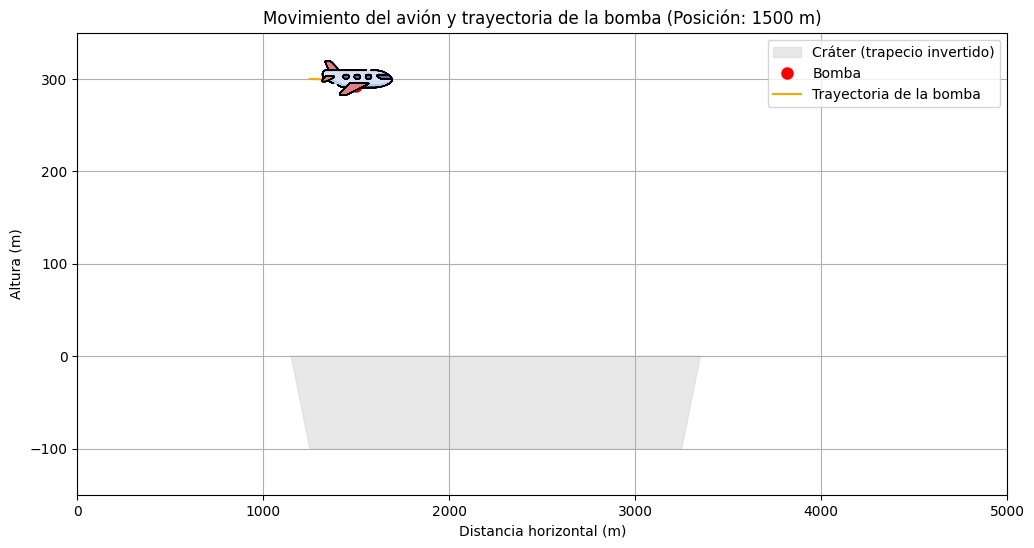

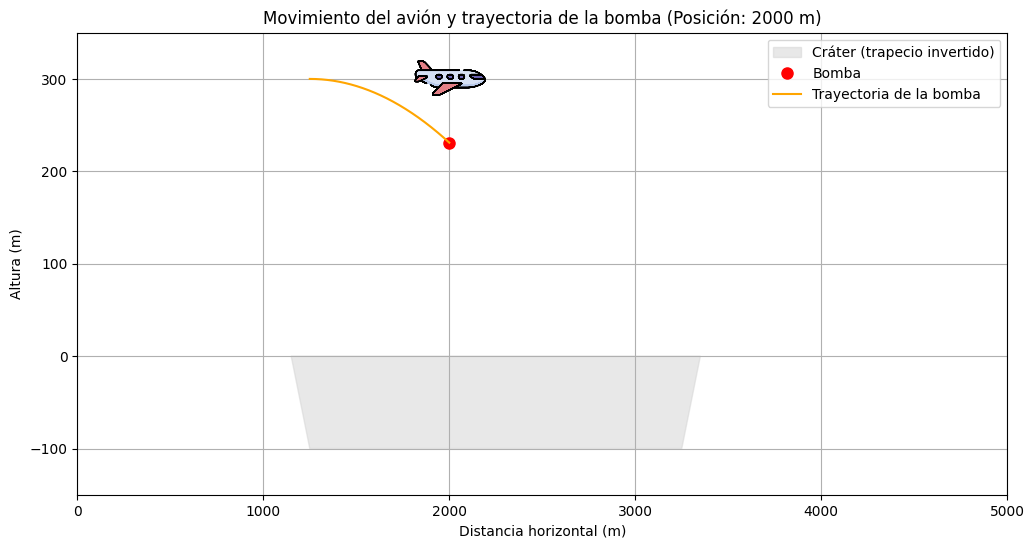

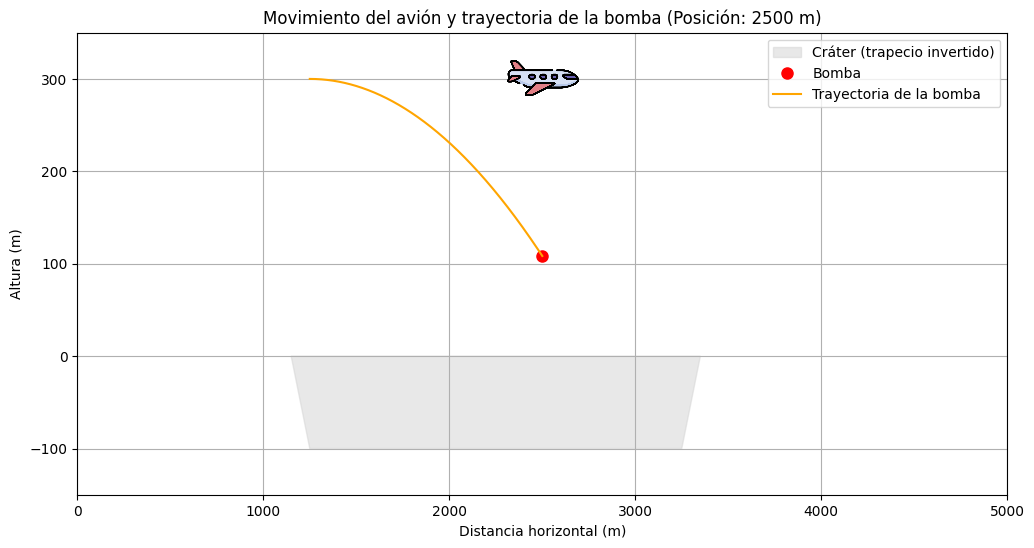

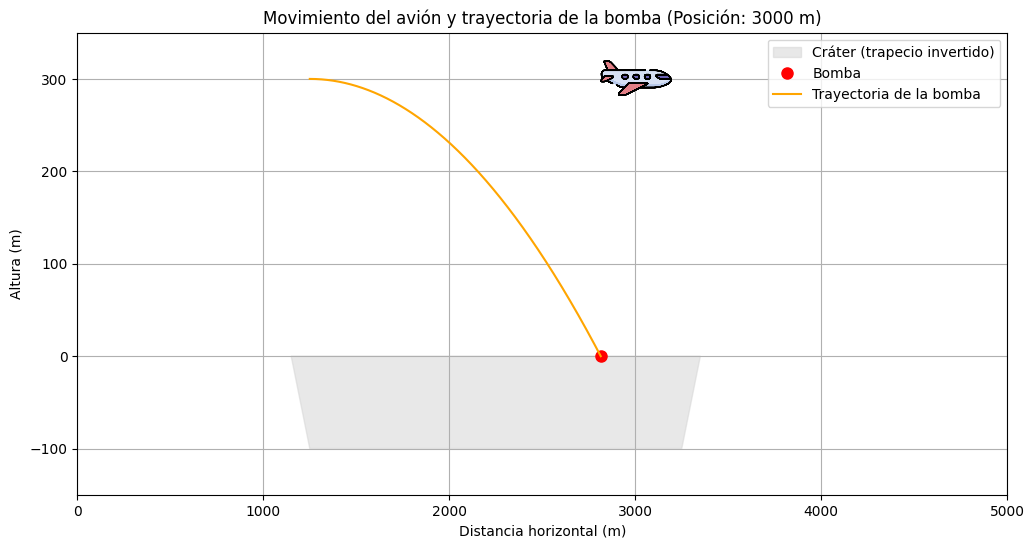

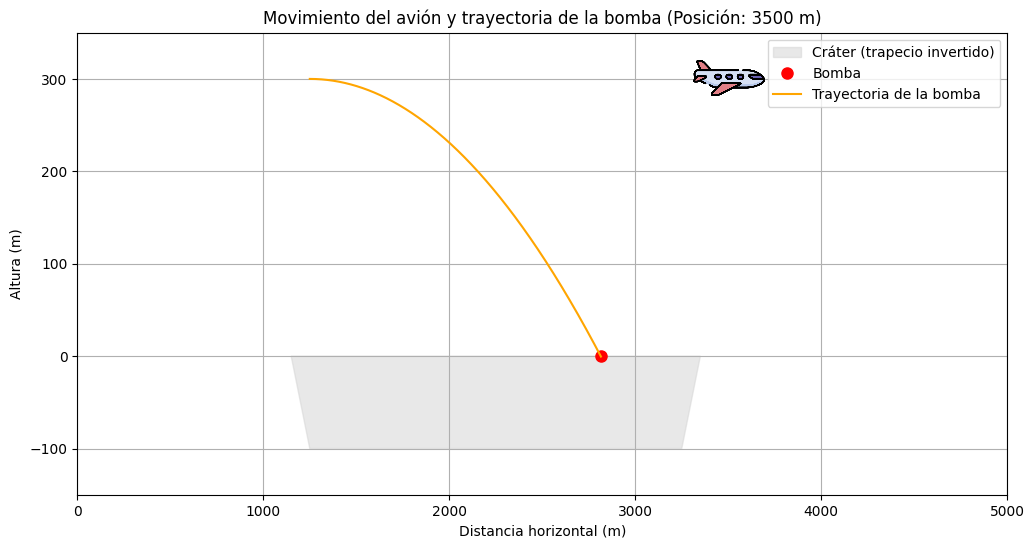

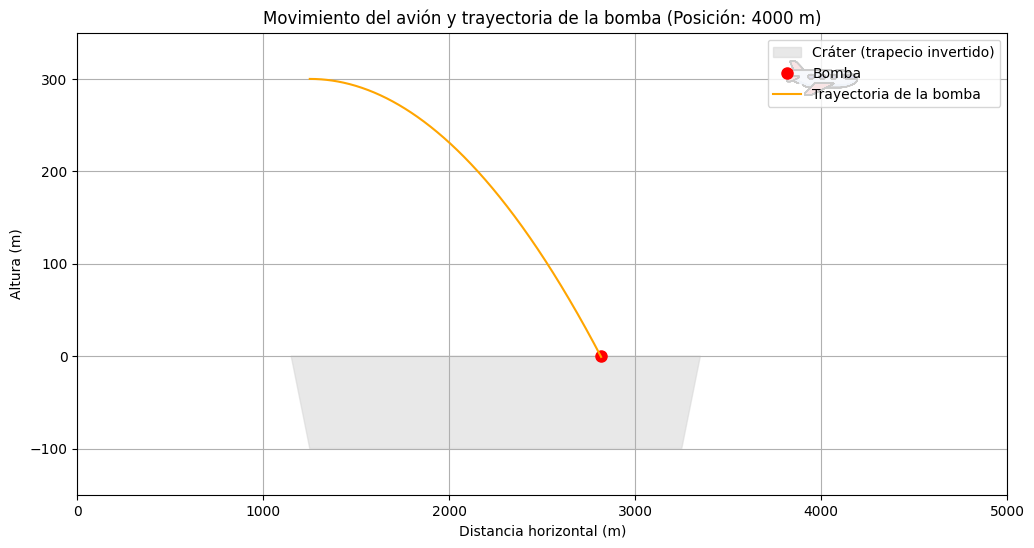

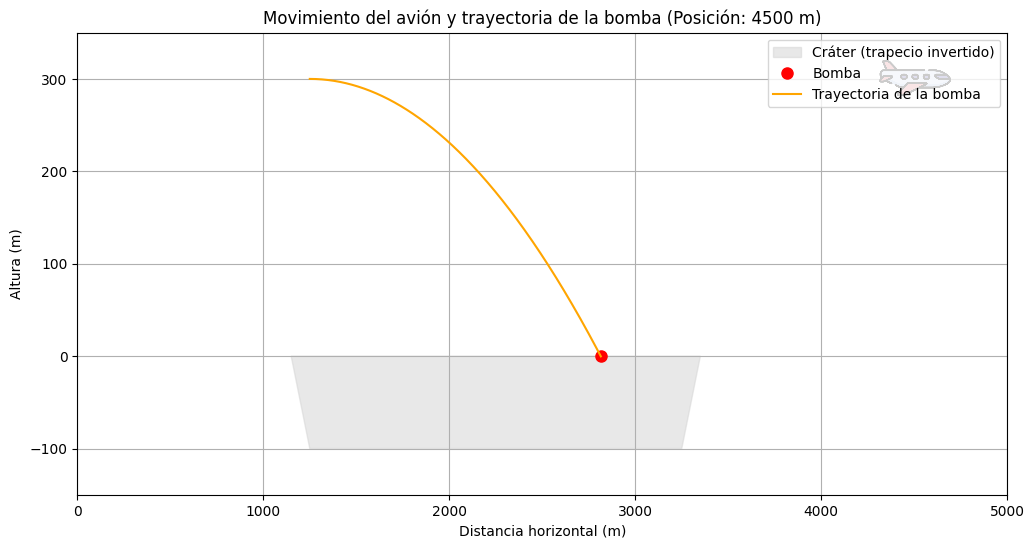

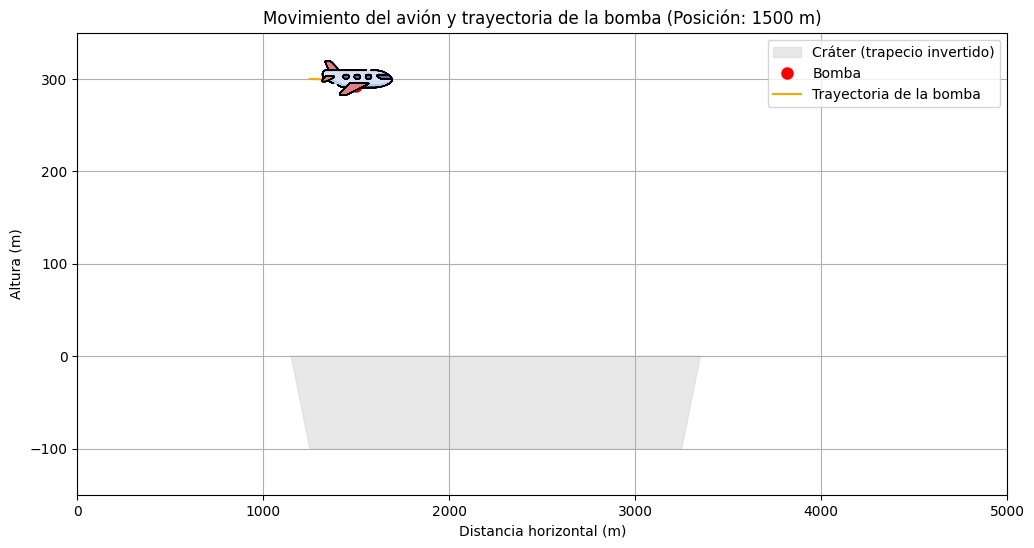

KeyboardInterrupt: 

In [ ]:


'''
ha = 300
hc = -100
L = 2000
alpha = np.radians(45)
d = 1250
v0 = 200

'''
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Parámetros
ha = 300  # Altura inicial del avión
hc = -100  # Altura del fondo del cráter
L = 2000  # Longitud horizontal del cráter
alpha = np.radians(45)  # Ángulo de las paredes del cráter
d = 1250  # Distancia inicial del avión desde el borde del cráter
v0 = 200  # Velocidad inicial de la bomba

g = 9.81

# Funciones de la trayectoria de la bomba
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

# Coordenadas del cráter
x_crater = [
    d,
    d + (hc / np.tan(alpha)),
    d + L - (hc / np.tan(alpha)),
    d + L
]
y_crater = [hc, 0, 0, hc]

# Trayectoria de la bomba
x0 = d
y0 = ha
v0x = v0
v0y = 0
x_trayectoria = np.linspace(x0, x0 + L + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)

# Detectar impacto
impacto_x = None
impacto_y = None
for i in range(len(x_trayectoria)):
    # Si la bomba cae en el cráter (altura <= hc)
    if y_trayectoria[i] <= hc and d <= x_trayectoria[i] <= d + L:
        impacto_x = x_trayectoria[i]
        impacto_y = -100
        break
    # Si la bomba cae en el suelo (altura <= 0 fuera del cráter)
    elif y_trayectoria[i] <= 0:
        impacto_x = x_trayectoria[i]
        impacto_y = 0
        break

# Posiciones a las que el avión se moverá
posiciones = [1500, 2000, 2500, 3000, 3500, 4000, 4500] 

for x_avion in posiciones:
    # Crear figura y ejes en cada paso para asegurarse de que se ve el movimiento
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 5000)
    ax.set_ylim(hc - 50, ha + 50)

    # Dibujar el cráter
    ax.fill(x_crater, y_crater, color="lightgrey", label="Cráter (trapecio invertido)", alpha=0.5)

    # Ruta de la imagen del avión
    avion_imagen_ruta = r"C:\Users\Adrian Correa\Desktop\Proyecto-metodos\avion.png"
    img = plt.imread(avion_imagen_ruta)

    # Añadir el marcador del avión en la nueva posición
    avion_marker = AnnotationBbox(OffsetImage(img, zoom=0.1), (x_avion, ha), frameon=False)
    ax.add_artist(avion_marker)

    # Elementos de la bomba y trayectoria
    bomba, = ax.plot([], [], 'ro', label="Bomba", markersize=8)
    trayectoria_line, = ax.plot([], [], color="orange", label="Trayectoria de la bomba")

    # Si el avión pasa la posición donde lanza la bomba
    if x_avion >= d:
        # Calcular la trayectoria desde el punto de lanzamiento
        t_lanzamiento = np.linspace(0, (x_avion - x0) / v0x, 1000)
        x_trayectoria_lanzamiento = x0 + v0x * t_lanzamiento
        y_trayectoria_lanzamiento = y0 - 0.5 * g * t_lanzamiento**2

        # Detectar el punto de impacto durante el vuelo
        impacto_detectado = False
        for j in range(len(x_trayectoria_lanzamiento)):
            if y_trayectoria_lanzamiento[j] <= hc and d <= x_trayectoria_lanzamiento[j] <= d + L:
                impacto_x = x_trayectoria_lanzamiento[j]
                impacto_y = -100  # Ajustar para que caiga dentro del cráter en y = -100
                impacto_detectado = True
                break
            elif y_trayectoria_lanzamiento[j] <= 0:
                impacto_x = x_trayectoria_lanzamiento[j]
                impacto_y = 0
                impacto_detectado = True
                break

        # Dibujar la trayectoria de la bomba hasta el punto de impacto
        if impacto_detectado:
            trayectoria_line.set_data(x_trayectoria_lanzamiento[:j + 1], y_trayectoria_lanzamiento[:j + 1])
            bomba.set_data([impacto_x], [impacto_y])
        else:
            trayectoria_line.set_data(x_trayectoria_lanzamiento, y_trayectoria_lanzamiento)
            bomba.set_data([x_trayectoria_lanzamiento[-1]], [y_trayectoria_lanzamiento[-1]])

    # Configurar y mostrar el gráfico en cada iteración
    plt.legend()
    plt.grid()
    plt.title(f"Movimiento del avión y trayectoria de la bomba (Posición: {x_avion} m)")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.show()
    plt.pause(2.0)  # Pausa para que puedas ver cada etapa claramente




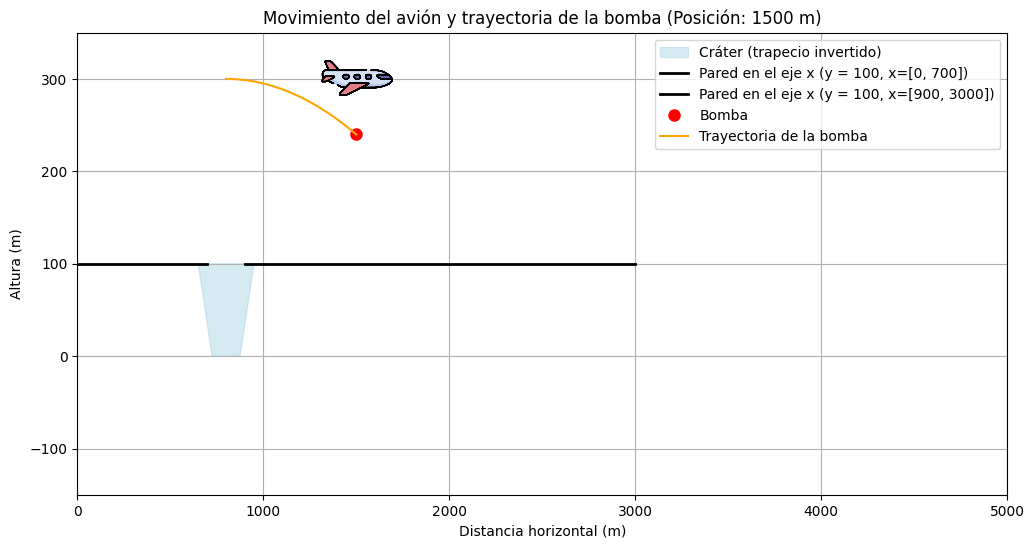

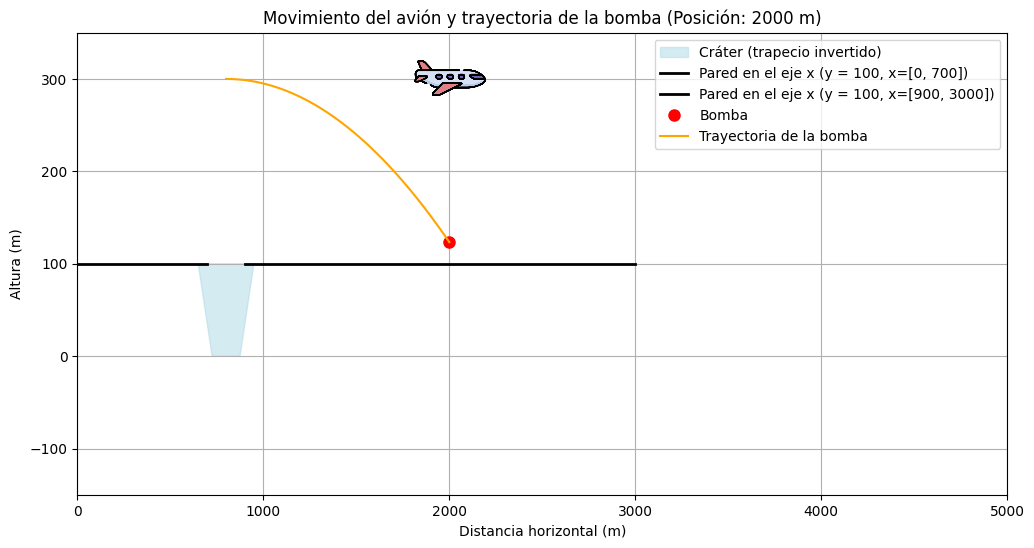

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Parámetros
ha = 300  # Altura inicial del avión
hc = -100  # Altura del fondo del cráter
L_top = 300  # Longitud de la base superior del cráter
L_bottom = 150  # Longitud de la base inferior del cráter
d = 800  # Distancia inicial del avión desde el borde del cráter
v0 = 200  # Velocidad inicial de la bomba
g = 9.81

# Función para crear el cráter (trapecio invertido)
def crear_trapecio_invertido(d, L_top, L_bottom, Hc):
   
    x_crater = [
        d - L_top / 2,  # Extremo superior izquierdo
        d - L_bottom / 2,  # Extremo inferior izquierdo
        d + L_bottom / 2,  # Extremo inferior derecho
        d + L_top / 2   # Extremo superior derecho
    ]
    y_crater = [Hc, 0, 0, Hc]
    return x_crater, y_crater

# Función para mover el cráter a otra distancia
def mover_crater(nueva_d, L_top, L_bottom, Hc):
    return crear_trapecio_invertido(nueva_d, L_top, L_bottom, Hc)

# Trayectoria de la bomba
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

x0 = d
y0 = ha
v0x = v0
v0y = 0
x_trayectoria = np.linspace(x0, x0 + L_top + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)

# Detectar impacto
impacto_x = None
impacto_y = None
for i in range(len(x_trayectoria)):
    # Si la bomba cae en el cráter (altura <= hc)
    if y_trayectoria[i] <= hc and 700 <= x_trayectoria[i] <= 900:
        impacto_x = x_trayectoria[i]
        impacto_y = hc
        break
    # Si la bomba cae en el suelo (altura <= 0 fuera del cráter)
    elif y_trayectoria[i] <= 0:
        impacto_x = x_trayectoria[i]
        impacto_y = 0
        break

# Coordenadas del cráter (usando la función crear_trapecio_invertido)
x_crater, y_crater = crear_trapecio_invertido(800, L_top, L_bottom, 100)

# Posiciones a las que el avión se moverá
posiciones = [1500, 2000, 2500, 3000, 3500]

for x_avion in posiciones:
    # Crear figura y ejes en cada paso para asegurarse de que se ve el movimiento
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 5000)
    ax.set_ylim(hc - 50, ha + 50)

    # Dibujar el cráter invertido
    ax.fill(x_crater, y_crater, color="lightblue", label="Cráter (trapecio invertido)", alpha=0.5)

    # Dibujar la pared en el eje x en el rango de x (0, 700) y (900, 3000) en y = 100
    x_wall_1 = np.linspace(0, 700, 100)
    y_wall_1 = np.ones_like(x_wall_1) * 100
    x_wall_2 = np.linspace(900, 3000, 100)
    y_wall_2 = np.ones_like(x_wall_2) * 100
    ax.plot(x_wall_1, y_wall_1, color="black", linewidth=2, label="Pared en el eje x (y = 100, x=[0, 700])")
    ax.plot(x_wall_2, y_wall_2, color="black", linewidth=2, label="Pared en el eje x (y = 100, x=[900, 3000])")

    # Ruta de la imagen del avión
    avion_imagen_ruta = r"C:\Users\Adrian Correa\Desktop\Proyecto-metodos\avion.png"
    img = plt.imread(avion_imagen_ruta)

    # Añadir el marcador del avión en la nueva posición
    avion_marker = AnnotationBbox(OffsetImage(img, zoom=0.1), (x_avion, ha), frameon=False)
    ax.add_artist(avion_marker)

    # Elementos de la bomba y trayectoria
    bomba, = ax.plot([], [], 'ro', label="Bomba", markersize=8)
    trayectoria_line, = ax.plot([], [], color="orange", label="Trayectoria de la bomba")

    # Si el avión pasa la posición donde lanza la bomba
    if x_avion >= d:
        # Calcular la trayectoria desde el punto de lanzamiento
        t_lanzamiento = np.linspace(0, (x_avion - x0) / v0x, 1000)
        x_trayectoria_lanzamiento = x0 + v0x * t_lanzamiento
        y_trayectoria_lanzamiento = y0 - 0.5 * g * t_lanzamiento**2

        # Detectar el punto de impacto durante el vuelo
        impacto_detectado = False
        for j in range(len(x_trayectoria_lanzamiento)):
            if y_trayectoria_lanzamiento[j] <= hc and 700 <= x_trayectoria_lanzamiento[j] <= 900:
                impacto_x = x_trayectoria_lanzamiento[j]
                impacto_y = hc  # Ajustar para que caiga dentro del cráter en y = hc
                impacto_detectado = True
                break
            elif y_trayectoria_lanzamiento[j] <= 0:
                impacto_x = x_trayectoria_lanzamiento[j]
                impacto_y = 0
                impacto_detectado = True
                break

        # Dibujar la trayectoria de la bomba hasta el punto de impacto
        if impacto_detectado:
            trayectoria_line.set_data(x_trayectoria_lanzamiento[:j + 1], y_trayectoria_lanzamiento[:j + 1])
            bomba.set_data([impacto_x], [impacto_y])
        else:
            trayectoria_line.set_data(x_trayectoria_lanzamiento, y_trayectoria_lanzamiento)
            bomba.set_data([x_trayectoria_lanzamiento[-1]], [y_trayectoria_lanzamiento[-1]])

    # Configurar y mostrar el gráfico en cada iteración
    plt.legend()
    plt.grid()
    plt.title(f"Movimiento del avión y trayectoria de la bomba (Posición: {x_avion} m)")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.show()
    plt.pause(2.0)  # Pausa para que puedas ver cada etapa claramente
